In [1]:
import numpy as np
import random 
import gym

import tensorflow as tf
#tf.enable_eager_execution()
import numpy as np
import pandas as pd

from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

In [2]:
# seed random number generators for reproducable results
np.random.seed (0)
random.seed(0)
tf.set_random_seed(0)
#tf.random.set_seed(0)

# SAMPLE DATA

In [3]:
# for details see: https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py
CART_POS="cartPos"
CART_VEL="cartVel"
PEND_POS="pendPos"
PEND_VEL="pendVel"
EPISODE="episode"
STEP="step"
ACTION="action"
    
def sample_data (episodes=10000, seed=0):
    env = gym.make ("CartPole-v1")
    env.np_random.seed(0)
    
    ### CREATE EMPTY Pandas dataset
    transitions = []

    ### SAMPLE DATA
    for episode in range (episodes):
        #print ("Start of episode %d" % episode)
        obs = env.reset()
        step =0
        done = False

        while step < 500 and not done:
            step += 1
            action = env.action_space.sample()

            transitions.append({CART_POS:obs[0], CART_VEL:obs[1], 
                             PEND_POS:obs[2], PEND_VEL:obs[3],
                             EPISODE:episode, STEP:step, ACTION:action})

            obs, reward, done, _ = env.step(action)

        #print ("  --> finished after %d steps" % step)
        
    return pd.DataFrame(transitions)


df = sample_data (episodes=200, seed=0)

In [4]:
df.dtypes

cartPos    float64
cartVel    float64
pendPos    float64
pendVel    float64
episode      int64
step         int64
action       int64
dtype: object

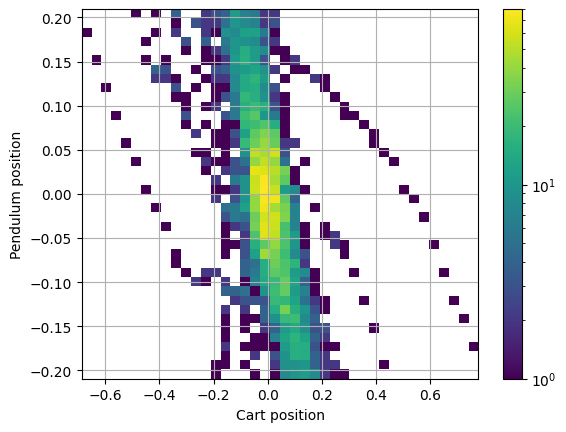

In [5]:
#plt.hist2d(, bins=(50, 50), cmap=plt.cm.Reds)
h = plt.hist2d(df[CART_POS], df[PEND_POS], bins=40, norm=LogNorm())
plt.colorbar(h[3])
plt.grid()
plt.xlabel ("Cart position")
plt.ylabel ("Pendulum position")
plt.show()


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

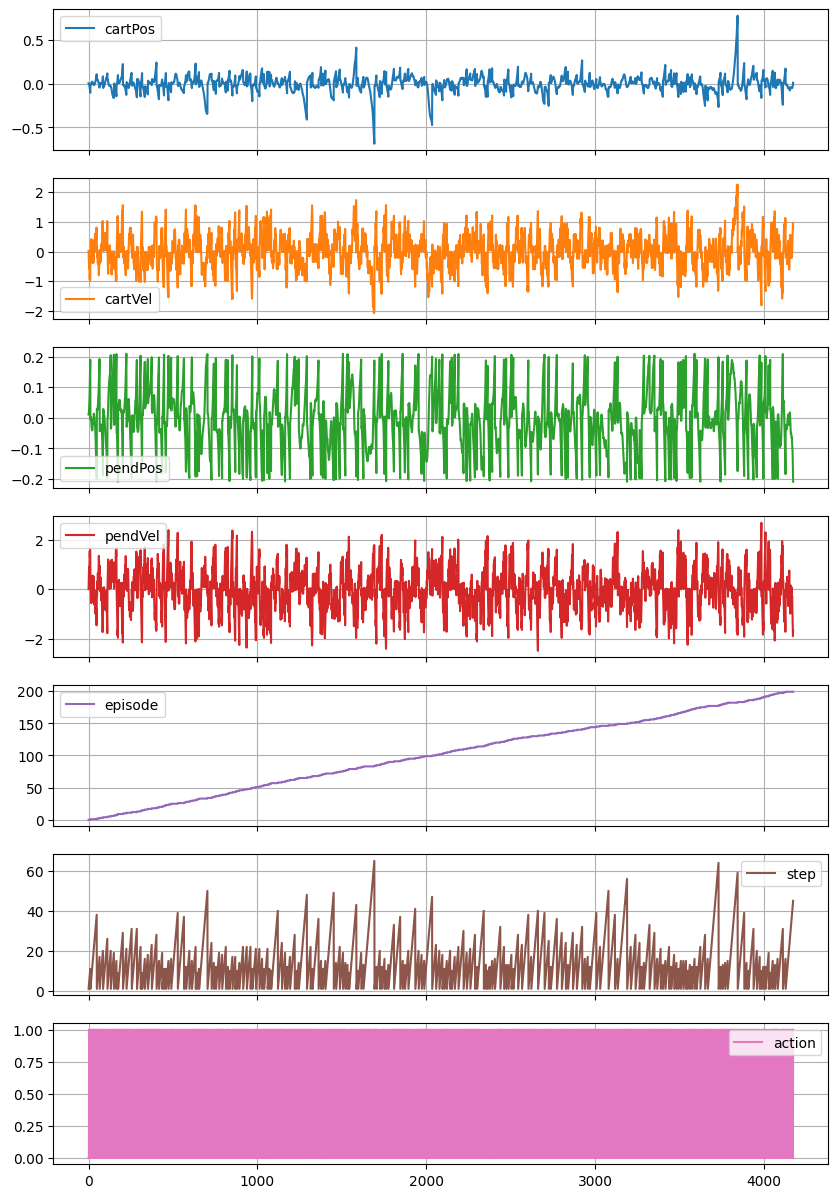

In [6]:
df.plot(subplots=True, figsize=(10,15), grid=True)

# Generate pattern data 

In [7]:
#############################################
#### HELPER FUNCTIONS FOR PATTERN GENERATION
#############################################
def create_training_data(data, input_col, target_col, window_size=1, training_pattern_percent=0.7):

    data_train = data

    mean_in, std_in = mean_and_std(input_col, data_train)
    mean_out, std_out = mean_and_std(target_col, data_train)
    #data_plot.plot_hist_df(data_train, input_col)
    #data_plot.plot_timeseries_df(data_train, input_col)
    print(f"mean in = {mean_in}" )
    print(f"std in = {std_in}")
    print(f"mean out =  {mean_out}")
    print(f"std out = {std_out}")

    grouped = data_train.groupby(['episode'])

    inputs_all = []
    labels_all = []

    for g in grouped:
        # be sure that data inside a group is not shuffled # not sure if needed
        g = g[1].sort_values(by='step')

        past_history = window_size   # t-3, t-2, t-1, t
        future_target = 0  # t+1
        STEP = 1 # no subsampling of rows in data, e.g. only every i'th row

        # use pandas.DataFrame.values in order to get an numpy array from an pandas.DataFrame object

        inputs, labels = multivariate_data(dataset=g[input_col][:].values, target=g[target_col][:].values,
                                        start_index=0, end_index=g[input_col][:].values.shape[0]-future_target,
                                        history_size=past_history, target_size=future_target, step=STEP,
                                        single_step=True)

        ## Append data to whole set of patterns
        for i in range (0, len(inputs)):
            inputs_all.append(inputs[i])
            labels_all.append(labels[i])
  
    length = len(inputs_all)

    c = list(zip(inputs_all, labels_all))
    np.random.shuffle(c)
    inputs_all, labels_all = zip(*c)

    split = int(training_pattern_percent * length)

    inputs_all = np.array(inputs_all)
    labels_all = np.array(labels_all)

    return ((inputs_all[0:split], labels_all[0:split]), (inputs_all[split:], labels_all[split:])), mean_in, std_in, mean_out, std_out


def mean_and_std(columns, data):
    mean = np.zeros(len(columns))
    std = np.zeros(len(columns))
    index = 0
    for c in columns:
        mean[index], std[index] = get_normalizations(data[c])
        index = index + 1
    return mean, std

def get_normalizations(data):
    mean = data.mean()
    std = data.std()
    return mean, std

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
       end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data, dtype=np.float32), np.array(labels, dtype=np.float32)



def prepare_data(df, input_col, target_col, window_size, training_batch_size=50, validation_batch_size=50, training_pattern_percent=0.7):
    
    global x_train_multi, y_train_multi
    
    ###################
    ## PREPARE DATASET
    ###################
    ((x_train_multi, y_train_multi), (x_val_multi, y_val_multi)), mean_in, std_in, mean_out, std_out = \
                                    create_training_data(df, input_col, target_col, window_size=window_size,
                                                        training_pattern_percent=training_pattern_percent)

    print('trainData: Single window of past history : {}'.format(x_train_multi[0].shape))
    print('trainData: Single window of future : {}'.format(y_train_multi[1].shape))
    print('valData: Single window of past history : {}'.format(x_val_multi[0].shape))
    print('valData: Single window of future : {}'.format(y_val_multi[1].shape))
    print('trainData: number of trainingsexamples: {}'.format(x_train_multi.shape))
    print('valData: number of trainingsexamples: {}'.format(x_val_multi.shape))

    train_data = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
    #train_data = train_data.cache().shuffle(max_training_pattern).batch(training_batch_size).repeat()
    train_data = train_data.shuffle(x_train_multi.shape[0]).batch(training_batch_size).repeat()

    val_data = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
    val_data = val_data.batch(validation_batch_size).repeat()
    input_shape = x_train_multi[0].shape[-2:]
    return train_data, val_data, input_shape, mean_in, std_in, mean_out, std_out


In [8]:
window_size=4
input_col = [CART_POS, CART_VEL, PEND_POS, PEND_VEL, ACTION]
target_col = [CART_POS, CART_VEL, PEND_POS, PEND_VEL]

train_data, val_data, input_shape, mean_in, std_in, mean_out, std_out =  \
            prepare_data(df, input_col, target_col, window_size=window_size, training_pattern_percent=0.7)

print ("Input-Shape: ", input_shape)

mean in = [-0.00239877  0.01649571 -0.00437029 -0.04325419  0.51017964]
std in = [0.08985853 0.55698192 0.09158072 0.81452264 0.49995624]
mean out =  [-0.00239877  0.01649571 -0.00437029 -0.04325419]
std out = [0.08985853 0.55698192 0.09158072 0.81452264]
trainData: Single window of past history : (4, 5)
trainData: Single window of future : (4,)
valData: Single window of past history : (4, 5)
valData: Single window of future : (4,)
trainData: number of trainingsexamples: (2362, 4, 5)
valData: number of trainingsexamples: (1013, 4, 5)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Input-Shape:  (4, 5)


# Create Cartpole state-transition model

In [9]:
def build_single_step_model(mean_in, std_in, mean_out, std_out, input_shape, optimizer=tf.keras.optimizers.RMSprop()):

    print(f"mean = {mean_in}, std = {std_in}, mean = {mean_out}, std = {std_out}")
    single_step_model = tf.keras.models.Sequential()
        
    single_step_model.add(tf.keras.layers.Lambda(lambda x: (x - mean_in) / std_in, input_shape=input_shape)) #, dtype=np.float32))
    #single_step_model.add(tf.keras.layers.Flatten())
    #single_step_model.add(tf.keras.layers.Dense(20, activation="sigmoid"))
    single_step_model.add(tf.keras.layers.LSTM(50, input_shape=input_shape, dtype=np.float32))
    single_step_model.add(tf.keras.layers.Dense(len(mean_out), activation="linear"))

    single_step_model.compile(optimizer=optimizer, loss="mse")

    return single_step_model

In [10]:
modelpath="model.h5"
max_epochs=1000
steps_per_epoch = 100
validation_steps = 100
validation_freq = 1

es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True, verbose=True)
mc_trainLoss_callback = tf.keras.callbacks.ModelCheckpoint(filepath="%s.bestTrainLoss" % modelpath, monitor='loss', verbose=1, save_best_only=True, mode=min)
mc_valLoss_callback = tf.keras.callbacks.ModelCheckpoint(filepath="%s.bestValLoss" % modelpath, monitor='val_loss', verbose=1, save_best_only=True, mode=min)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = ".\model_logs_tb", histogram_freq=1)


model = build_single_step_model(mean_in, std_in, mean_out, std_out, input_shape)
history = model.fit(train_data, epochs=max_epochs, steps_per_epoch=steps_per_epoch,
                        validation_data=val_data, validation_steps=validation_steps, validation_freq=validation_freq,
                        callbacks=[mc_trainLoss_callback, mc_valLoss_callback, es_callback, tensorboard_callback])
model.save(modelpath)


mean = [-0.00239877  0.01649571 -0.00437029 -0.04325419  0.51017964], std = [0.08985853 0.55698192 0.09158072 0.81452264 0.49995624], mean = [-0.00239877  0.01649571 -0.00437029 -0.04325419], std = [0.08985853 0.55698192 0.09158072 0.81452264]
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 100 steps, validate on 100 steps
Epoch 1/1000
 93/100 [==========================>...] - ETA: 0s - loss: 0.0540
Epoch 00001: loss improved from inf to 0.05051, saving model to model.h5.bestTrainLoss

Epoch 00001: val_loss improved from inf to 0.00396, saving model to model.h5.bestValLoss
100/100 [==============================] - 1s 11ms/step - loss: 0.0505 - val_loss: 0.0040
Epoch 2/1000
 90/100 [==========================>...] - ETA: 0s - loss: 0.0014
Epoch 00002: loss improved from 0.05051 to 0.00134, saving model to model.h5.bestTrainLoss

Epoch 00002: val_loss improved from 0.00396 to 0.00083, saving model to model.h5.bestValLoss
100/100 [==============

# Evaluate model quality

### Sample new data from environment and determine episode with most steps

In [11]:
dfEval = sample_data(episodes=100, seed=111)
dfEval.describe()
row_max_steps = dfEval[dfEval.step == dfEval.step.max()]
dfEval = dfEval[dfEval.episode==int(row_max_steps.episode)]

### Extract prediction bounds from training data

In [12]:
output_min = y_train_multi.min(axis=0)
output_max = y_train_multi.max(axis=0)
print ("min(output)_data: ", output_min)
print ("max(output)_data: ", output_max)

min(output)_data:  [-0.68661404 -2.05962    -0.2093295  -2.4089804 ]
max(output)_data:  [0.7364924  2.2458823  0.20901568 2.387896  ]


### Evaluate neural network

In [14]:
import collections

# load model
#model = tf.keras.models.load_model(modelpath, compile=False)
model = tf.keras.models.load_model("model.h5.bestValLoss", compile=False)
#model = tf.keras.models.load_model("model.h5.bestTrainLoss", compile=False)
#############################################################################
# in case of error: AttributeError: 'str' object has no attribute 'decode'
# => Downgrade h5py package to version 2.10.0: pip install h5py==2.10.0
#############################################################################

# FIFO-buffer that keeps the neural state
stateBuffer = collections.deque(maxlen=window_size)

# outputs of neural network will be stored here
transitions = []

for i in range (len(dfEval)): 
                            
    # estimation of first state
    if i < window_size: 
        state_data = np.float32([dfEval[CART_POS].values[i], dfEval[CART_VEL].values[i],
                               dfEval[PEND_POS].values[i], dfEval[PEND_VEL].values[i],
                               dfEval[ACTION].values[i]])
        stateBuffer.append(state_data)
        #print ("Filling initState: %s" % state_data)
    
    # predict successor state
    else: 
        
        ###########################
        # recall of neural network
        ###########################
        state = np.array([list(stateBuffer)])
        if i==5:
            print (state)
        netOutput = model.predict(np.float32(state))[0]
        
        # clip output to observed data bounds
        netOutput = np.clip(netOutput, output_min, output_max)
        
        # check if value bound was hit
        if np.any(netOutput == output_min) or np.any(netOutput == output_max):
            print ("Bound-hit at step: ", i, " => terminating further evaluation")
            break
        
        # append plotting data
        transitions.append ({
            CART_POS:netOutput[0], CART_VEL:netOutput[1],
            PEND_POS:netOutput[2], PEND_VEL:netOutput[3]
        })
        
        # update RNN state
        stateBuffer.append(np.float32([netOutput[0], netOutput[1], 
                                       netOutput[2], netOutput[3], 
                                       dfEval[ACTION].values[i]]))
        
dfNet = pd.DataFrame(transitions)

[[[ 0.0478858   0.20525539  0.02300473 -0.33112016  1.        ]
  [ 0.05199091  0.40004244  0.01638233 -0.6164607   1.        ]
  [ 0.05999176  0.5949317   0.00405312 -0.9039392   1.        ]
  [ 0.07198525  0.7893147  -0.01354137 -1.1910026   1.        ]]]
Bound-hit at step:  64  => terminating further evaluation


### Plot results

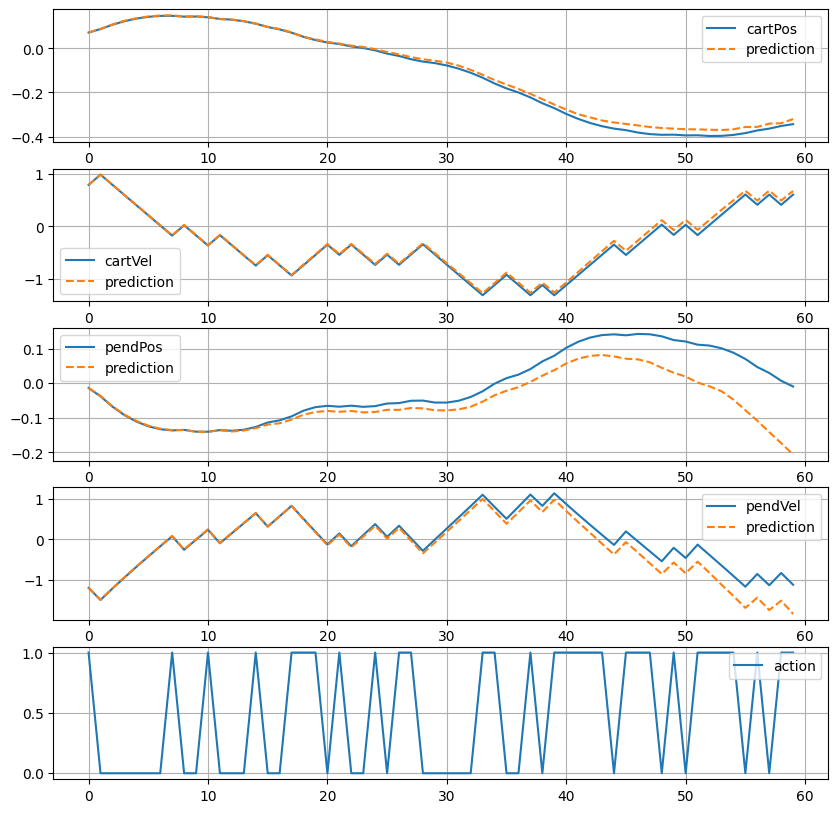

In [15]:
fig, axs = plt.subplots (5, 1, figsize=(10,10))

fields = [CART_POS, CART_VEL, PEND_POS, PEND_VEL]

for i in range (len(fields)):
    f = fields[i]
    axs[i].plot(range (len(dfNet)), dfEval[f].values[window_size:window_size+len(dfNet)], label=f)
    axs[i].plot(range (len(dfNet)), dfNet[f].values, label="prediction", ls="--")
    axs[i].grid()
    axs[i].legend(loc="best")
    
axs[4].plot(range (len(dfNet)), dfEval[ACTION].values[window_size:window_size+len(dfNet)], label=ACTION)
axs[4].grid()
axs[4].legend(loc="best")


In [16]:
tf.executing_eagerly()

False